# Compute files for cloud plots for models

In [1]:
%load_ext autoreload
%autoreload 2


import useful_scit.util.log as log
import numpy as np
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud
from datetime import timedelta

In [2]:

import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud, \
    rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

from timeit import default_timer as timer

from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from bs_fdbck.constants import path_measurement_data

In [4]:
xr.set_options(keep_attrs=True)
log.ger.setLevel(log.log.INFO)

## General settings

In [5]:

select_station = 'SMR'

calc_seasons = ['ALL_year']

tau_lims = [5, 50]
r_eff_lim = 1
cloud_top_temp_above = -15
cld_water_path_above = 50

postproc_data = path_measurement_data / 'model_station' / select_station
postproc_data_obs = path_measurement_data / select_station / 'processed'

In [6]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 = '2015-01-01'
to_time2 = '2019-01-01'
sel_years_from_files = ['2012', '2014', '2015', '2018']

In [7]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f' % (*lon_lims,)
str_latlim = '%.1f-%.1f' % (*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

#### Daytime values


Set the daytime to be from 10 to 17 each day

In [8]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [9]:
models = ['ECHAM-SALSA', 'NorESM', 'EC-Earth']
mod2cases = {'ECHAM-SALSA': ['SALSA_BSOA_feedback'],
             'NorESM': ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth': ['ECE3_output_Sara'],
             }
di_mod2cases = mod2cases.copy()

In [10]:
dic_df_station = dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data / f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        # dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv


## Calculate datasets for each model

### NorESM

In [11]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [12]:
cases = [case_name]

#### Path input data

In [13]:
path_input_data_noresm = path_extract_latlon_outdata / case_name

#### Filenames to store products in 3d/2d

In [14]:
# Filename for case1 concatinated over time
fn1 = path_extract_latlon_outdata / case_name1 / f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

# Select variables and time:
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
# Sortby time:
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'

# Filename for case1 concatinated over time

fn2 = path_extract_latlon_outdata / case_name2 / f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

# Select variables and time:
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
# Sortby time:
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

# Concatinated case1 and case2
fn_comb = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
# Concatinated only

# fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_final_csv = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [15]:
print(fn_comb_lev1_final_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final_wet_season.csv


#### Define NorESM station variables and cloud variables

In [16]:
varl_st = ['SOA_NA', 'SOA_A1', 'OM_NI', 'OM_AI', 'OM_AC', 'SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC', 'SO4_PR',
           'BC_N', 'BC_AX', 'BC_NI', 'BC_A', 'BC_AI', 'BC_AC', 'SS_A1', 'SS_A2', 'SS_A3', 'DST_A2', 'DST_A3',
           'N50', 'N100', 'N150', 'N200', 'N500',
           #           'N50-500','N100-500', 'N150-500', 'N200-500',
           # 'OA',
           ]
varl_st_computed = ['OA', 'T_C', ]

varl_cl = ['TOT_CLD_VISTAU', 'TOT_ICLD_VISTAU', 'TGCLDCWP', 'TGCLDLWP', 'TGCLDIWP',
           'TOT_CLD_VISTAU_s', 'TOT_ICLD_VISTAU_s', 'optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL', 'ACTNL', 'TGCLDLWP',
           'FSDSC', 'FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC', 'FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

#### Concatinate files, compute 2D fields from 3D fields (compute tau) and sortby time.

In [17]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks={'time': 96}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks={'time': 96}, engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)

        varl = list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0], sel_years_from_files[1]))  # .sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2], sel_years_from_files[3]))  # .sortby('time')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()

    if not fn1_3.exists():
        ds_mod1 = xr.open_dataset(fn1_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod1 = compute_total_tau(ds_mod1)
        ds_mod1 = ds_mod1.isel(lev=model_lev_i)
        ds_mod1 = ds_mod1.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
        print('hey 1')
        with ProgressBar():
            results = delayed_obj.compute()
    if not fn2_3.exists():
        ds_mod2 = xr.open_dataset(fn2_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = compute_total_tau(ds_mod2)
        ds_mod2 = ds_mod2.isel(lev=model_lev_i)
        ds_mod2 = ds_mod2.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
        print('hey')
        with ProgressBar():
            results = delayed_obj.compute()

    ds_mod = xr.open_mfdataset([fn1_3, fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True, )

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

    # ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

##### Check:

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


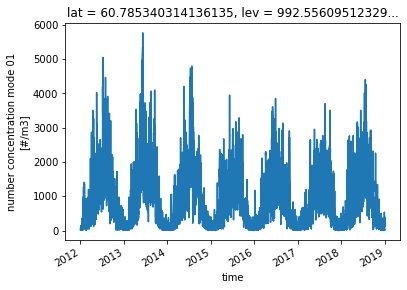

In [18]:
ds_mod = xr.open_dataset(fn_comb, engine='netcdf4', chunks={'time': 48})
(1e-6 * ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

#### Change units and compute variables

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [19]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb, engine='netcdf4').isel(ilev=model_lev_i)
    # ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        nbnd=0
    ).squeeze()
    # ds_all = broadcase_station_data(ds_all, lon = lon_smr, lat = lat_smr)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)

    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [20]:
df_comb_station = dic_df_station['NorESM']['OsloAero_intBVOC_f09_f09_mg17_fssp']
df_comb_station.head()

,station,ACTREL,lev,BC_A,BC_AC,BC_AI,BC_AX,BC_N,BC_NI,COAGNUCL,...,SOA,OAG,OA,POA,SO4,hour,is_JJA,is_JA,isSummer,year
time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 02:00:00,SMR,0.0,992.556095,7.165361e-11,2.874122e-12,1.062304e-11,2.001164e-11,1.403718e-10,1.900030e-16,0.000004,...,0.082910,2.276897,2.274975,2.192066,0.427151,0,False,False,False,2012
2012-01-02 03:00:00,SMR,0.0,992.556095,6.776110e-11,3.136896e-12,1.015449e-11,2.030955e-11,1.432439e-10,2.271426e-16,0.000004,...,0.075473,2.272214,2.270285,2.194812,0.394888,1,False,False,False,2012
2012-01-02 04:00:00,SMR,0.0,992.556095,6.566561e-11,3.785762e-12,1.001973e-11,2.074075e-11,1.463301e-10,2.643147e-16,0.000004,...,0.072424,2.328864,2.326991,2.254567,0.398770,2,False,False,False,2012
2012-01-02 05:00:00,SMR,0.0,992.556095,6.431399e-11,6.004582e-12,1.001325e-11,2.124108e-11,1.503158e-10,3.295160e-16,0.000004,...,0.070217,2.416752,2.414983,2.344767,0.406945,3,False,False,False,2012
2012-01-02 06:00:00,SMR,0.0,992.556095,6.334269e-11,8.331037e-12,9.825345e-12,2.174707e-11,1.512403e-10,3.650696e-16,0.000004,...,0.068667,2.396805,2.395117,2.326450,0.410223,4,False,False,False,2012


In [21]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel

#### Open dataset computed above

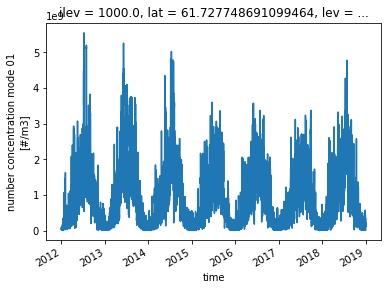

In [22]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks={'lon': 1}, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['NCONC01'].isel(lat=1, lon=1).plot()

#### Shift timezone

In [23]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

[########################################] | 100% Completed | 29.1s
shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells.

In [24]:
ds_smll = ds_all[['NCONC01']]

In [25]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [26]:
varl_tmp = varl_st + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [27]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

OA
SO4_NA
SO4_A1
N50
N150
N100
DST_A3
BC_N
DST_A2
SS_A3
BC_AX
T_C
OM_AC
BC_NI
OM_AI
SOA_NA
BC_A
SS_A2
N200
SO4_A2
SO4_PR
BC_AC
OM_NI
SOA_A1
SS_A1
BC_AI
SO4_AC


#### Replace all values by station values

In [28]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

##### Controle plots

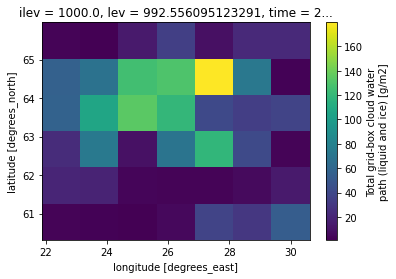

In [29]:
ds_all['TGCLDCWP_incld'].sel(time='2012-05-30 02:00:00').plot()

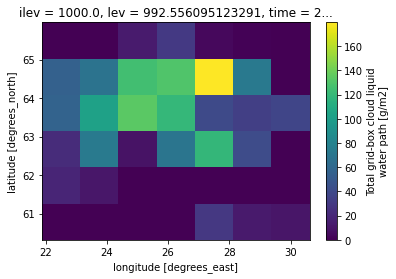

In [30]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

#### Finally steps

In [31]:
dic_ds = dict()
dic_ds[case_name_noresm] = ds_all

##### Rename vars

In [32]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

#### Save netcdf file

In [33]:
if not fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

#### Controle plots

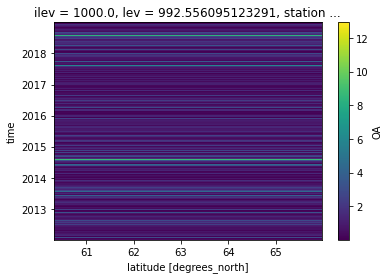

In [34]:
dic_ds[case_name_noresm]['OA'].mean('lon').plot()

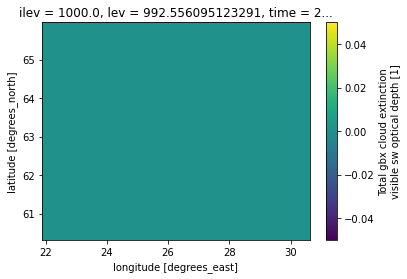

In [35]:
dic_ds[case_name_noresm]['COT'].sel(time='2018-01-07 00:00:00').plot()

(0.0, 400.0)

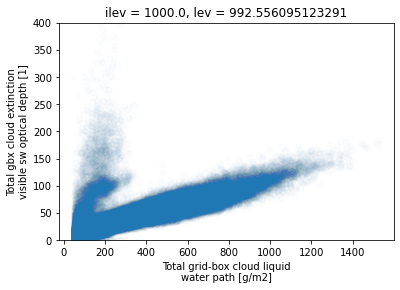

In [36]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='CWP', y='COT', alpha=0.01)
plt.ylim([0, 400])

(0.0, 400.0)

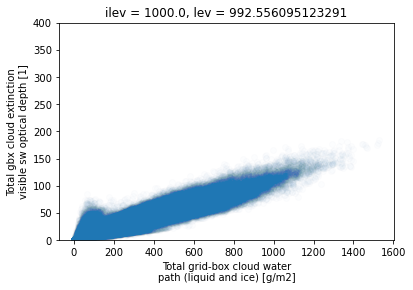

In [37]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='TGCLDCWP', y='TOT_CLD_VISTAU_s', alpha=0.01)
plt.ylim([0, 400])

#### Save final csv

In [38]:
ds_noresm = ds_all.copy()

In [39]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if not _fn_csv.exists():
        start = timer()

        dic_df = get_dic_df_mod(
            dic_ds,
            select_hours_clouds=True,
            summer_months=season2month[seas],
            from_hour=daytime_from,
            # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50]),
            kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above, tau_bounds=tau_lims),

            # kwrgs_mask_clouds = dict(min_reff = 1),
            to_hour=daytime_to,
        )

        df_mod = dic_df[case_name_noresm]

        # df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start)  # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end - start)} seconds')
        print(f'That is  {((end - start) / 60)} minuts')

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_finalALL_year.csv


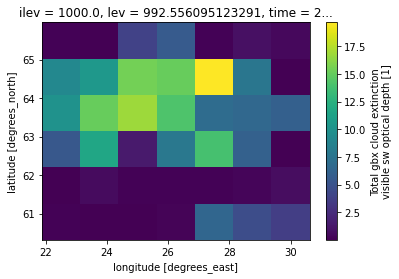

In [40]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 02:00:00').plot()

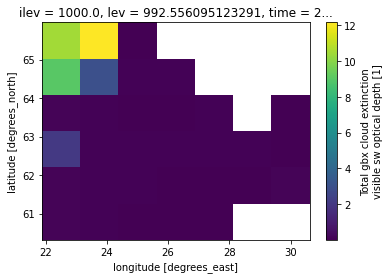

In [41]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 23:00:00').plot()

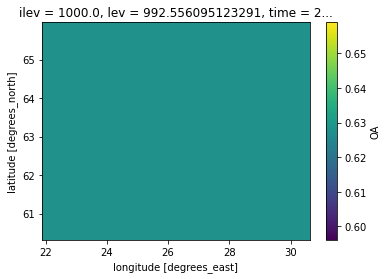

In [42]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA'].sel(time='2012-05-30 02:00:00').plot()

### ECHAM-SALSA

#### Names etc

In [43]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res = 'locations'
model_name = 'ECHAM-SALSA'
model_name_echam = 'ECHAM-SALSA'

#### Input path

In [44]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam

In [45]:

cases_echam = [case_name_echam]

#### Station variables  and others

In [46]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]

varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    # 'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]



#### Filenames:

In [47]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

In [48]:
fl_open = []

for v in varl_cl_echam + varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    # print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [49]:
fl_open = list(set(fl_open))

In [ ]:
ds_all = xr.open_mfdataset(fl_open, decode_cf=False)

In [ ]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    # ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    ds_all = ds_all.isel(lev=model_lev_i)

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_smr, lat = lat_smr)

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

#### Use station data computed before:

In [ ]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Compute Nx-500

In [ ]:

for v in ['N50', 'N100', 'N200', 'N150', 'N25', 'N70', 'N250']:
    if v in df_comb_station.columns:
        df_comb_station[v + '-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v + '-500')
        print(v)

In [ ]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [ ]:
ds_all = xr.open_dataset(fn_final_echam, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()  # .isel(lat=0, time=0).plot()#.shape#.plot()

In [ ]:
ds_all['time'].attrs['timezone'] = 'utc'

In [ ]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

#### Fix time for echam

In [ ]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

#### Finally produce daily median dataset:

In [ ]:
dic_ds = dict()
dic_ds[case_name] = ds_all

##### Controle plots

In [ ]:
ds_all['cwp'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, color='r')

In [ ]:
ds_all['cwp_incld2'] = ds_all['cwp'] / ds_all['cl_clfr_max']

In [ ]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

In [ ]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=0.5, ax=ax.twinx(), color='r')
plt.xscale('log')

#### Mask values where cloud time max is less than 10 percent

In [ ]:
ds_all = ds_all.where(ds_all['cl_time_max'] > .1)

#### Shift timezone

In [ ]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

#### Broadcast computed variables so that only station value is in the gridcells.

In [ ]:
ds_smll = ds_all[['mmrtrN100']]

In [ ]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

In [ ]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr, lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [ ]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr, lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [ ]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [ ]:
varl_tmp = varl_st_echam + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [ ]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

#### Replace all values by station values

In [ ]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

In [ ]:
ds_all.where((ds_all['cwp_incld'] > 50) & (ds_all['cl_time_max'] > .1))['cod_incld'].plot.hist(bins=np.arange(-1, 50),
                                                                                               alpha=.5)

#### Final steps

In [ ]:
dic_ds = dict()
dic_ds[case_name_echam] = ds_all

##### Rename vars

In [ ]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

#### Save final csv

In [ ]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_echam]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

In [ ]:
df_mod.plot.scatter(x='CWP', y='COT')

In [ ]:
_fn_csv

### EC-Earth

#### Names etc

In [ ]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res = 'locations'
model_name = 'EC-Earth'
model_name_ec_earth = 'EC-Earth'

#### Input path:

In [ ]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [ ]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames:

In [ ]:
fn_intermediate_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [ ]:
fn_final_ec_earth_csv_stem

#### Open pre calculated extracted fields

In [ ]:
which = 'IFS'

In [ ]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'

In [ ]:
fl_open = []
# ds_list =[]
dic_ds = dict()

for which in ['IFS', 'IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')

#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [ ]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
)

##### Fix units, calc cloud properties etc.

In [ ]:
if not fn_intermediate_ec_earth.exists():

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds = rename_ifs_vars(_ds)

        _ds = fix_units_ec_earth(_ds)
        # _ds = calculate_incld_values_warmclouds(_ds)
        # _ds = extract_cloud_top(_ds)
        # _ds['lat'] = np.round(_ds['lat'], decimals=2)
        # _ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds = (
            _ds
            .assign(
                lat=lambda d: d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d: d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds

    ds = dic_ds['IFS']

    ds = calculate_incld_values_warmclouds(ds)

    ds = extract_cloud_top(ds)

    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev=model_lev_i)
        dic_ds[key] = ds_l

    ds_t = dic_ds['IFS_T']

    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U', 'V', 'temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']), ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()

#### Open file with fixed units and extracted cloud params:

In [ ]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)

##### Fix units and decode time

In [ ]:
ds_ifs['ttc'].attrs['units'] = 1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units'] == 1:
            ds_ifs[v].attrs['units'] = '1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

#### Overview plots

In [ ]:
ds_ifs['re_liq_cltop'].count('time').plot()

In [ ]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

In [ ]:
ds_ifs['cc_all'].mean('time').plot()

In [ ]:
ds_ifs['cc'].mean('time').plot()

In [ ]:
ds_ifs['ttc'].mean('time').plot()

In [ ]:
ds_ifs['re_liq'].isel(lat=2, lon=0).plot(x='time', linewidth=0, marker='.')

In [ ]:
ds_ifs['argmax'].mean('time').plot()

In [ ]:
ds_ifs['re_liq_cltop'].mean('time').plot()

In [ ]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

In [ ]:
ds_ifs['re_liq'].mean('time').plot()

In [ ]:
ds_ifs['tclw'].mean('time').plot()

In [ ]:
ds_ifs['cloud_time_norm'].mean('time').plot()

#### Masking and computing vars

##### Mask values where cloud fraction is less than 10 percent

In [ ]:
xr.set_options(keep_attrs=True)

In [ ]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop'] > .1)

##### Take only values where liquid cloud fraction is above 80%

In [ ]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp'] > .8)

In [ ]:
ds_ifs['liq_frac_cwp'].plot()

#### Shift timezone

In [ ]:

with ProgressBar():
    ds_ifs.load()

if ds_ifs['time'].attrs['timezone'] == 'utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

#### Use station data computed before:

In [ ]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [ ]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [ ]:
ds_ifs['temp'].plot()

##### Check time against station data

In [ ]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07', '2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07', '2012-08'))
(_ds1['temp'] - 273.15).groupby(_ds1['hour']).mean().sel(lat=lat_smr, lon=lon_smr, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [ ]:
varl_station_ec_earth = [
    'CCN0.20',
    'CCN1.00',
    'M_BCACS',
    'M_BCAII',
    'M_BCAIS',
    'M_BCCOS',
    'M_DUACI',
    'M_DUACS',
    'M_DUCOI',
    'M_DUCOS',
    'M_POMACS',
    'M_POMAII',
    'M_POMAIS',
    'M_POMCOS',
    'M_SO4ACS',
    'M_SO4COS',
    'M_SO4NUS',
    'M_SOAACS',
    'M_SOAAII',
    'M_SOAAIS',
    'M_SOACOS',
    'M_SOANUS',
    'M_SSACS',
    'M_SSCOS',
    'OA',
    'SOA',
    'N_ACI',
    'N_ACS',
    'N_AII',
    'N_AIS',
    'N_COI',
    'N_COS',
    'N_NUS',
    'RDRY_ACS',
    'RDRY_AIS',
    'RDRY_COS',
    'RDRY_NUS',
    'RWET_ACI',
    'RWET_ACS',
    'RWET_AII',
    'RWET_AIS',
    'RWET_COI',
    'RWET_COS',
    'RWET_NUS',
    'emiisop',
    'emiterp',
    'T',
    'DDRY_NUS',
    'DDRY_AIS',
    'DDRY_ACS',
    'DDRY_COS',
    'DWET_AII',
    'DWET_ACI',
    'DWET_COI',
    'N50',
    'N70',
    'N100',
    'N150',
    'N200',
    'N500',
    'N50-500',
    'N70-500',
    'N100-500',
    'N150-500',
    'N200-500',
    'OA',
    'POM',
    'SOA',
    'SOA2',
    'T_C',

]

In [ ]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [ ]:
ds_smll = ds_ifs[['temp']]

In [ ]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

##### Replace all values by station values

In [ ]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

#### Final adjustments


In [ ]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

##### Rename variables

In [ ]:
# calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [ ]:
ds = dic_ds[key]

In [ ]:
ds['r_eff'].plot(bins=np.linspace(3, 40));

In [ ]:
ds['CWP_unweigth'] = ds['tclw']

In [ ]:
ds['CWP_unweigth'].plot(bins=np.linspace(0, 500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0, 500), alpha=.5);

##### Controle plots normalizing by cloud fraction

In [ ]:
ds['r_eff'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc'] < .4).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

In [ ]:
ds['CWP'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

In [ ]:
ds['CWP_unweigth'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

#### Final save

In [ ]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas + '.csv')
    print(_fn_csv)

    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds,
                                select_hours_clouds=True,
                                summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim,
                                                       min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims
                                                       ),

                                )

        df_mod = dic_df[case_name_ec_earth]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

In [ ]:
print('Done')